# CS3263 Assignment 1 - Problem 2: Safe Missions on Mars

Welcome to the CS3263 Assignment 1 - Problem 2, you will complete the problem in this notebook!

* Group Member 1:
    - Name:
    - Student ID:


* Group Member 2:
    - Name:
    - Student ID:

## Overview
We will use the following Bayesian network with binary variables to model events in Persy the Mars Rover's adventures. In our `persy_net` network, the variables are: 

- **EquipmentFailure** (``E``): a rare malfunction in Persy's equipment.
- **SolarFlare** (``S``): a rare burst of solar activity affecting Mars.
- **AlertOfSensor** (``A``): an alert triggered if either an equipment failure or a solar flare occurs.
- **CommandSignal** (``C``): a signal sent from Mission Control when a sensor alert is detected.
- **DataTransmission** (``D``): a data transmission sent from Persy when a sensor alert is detected.


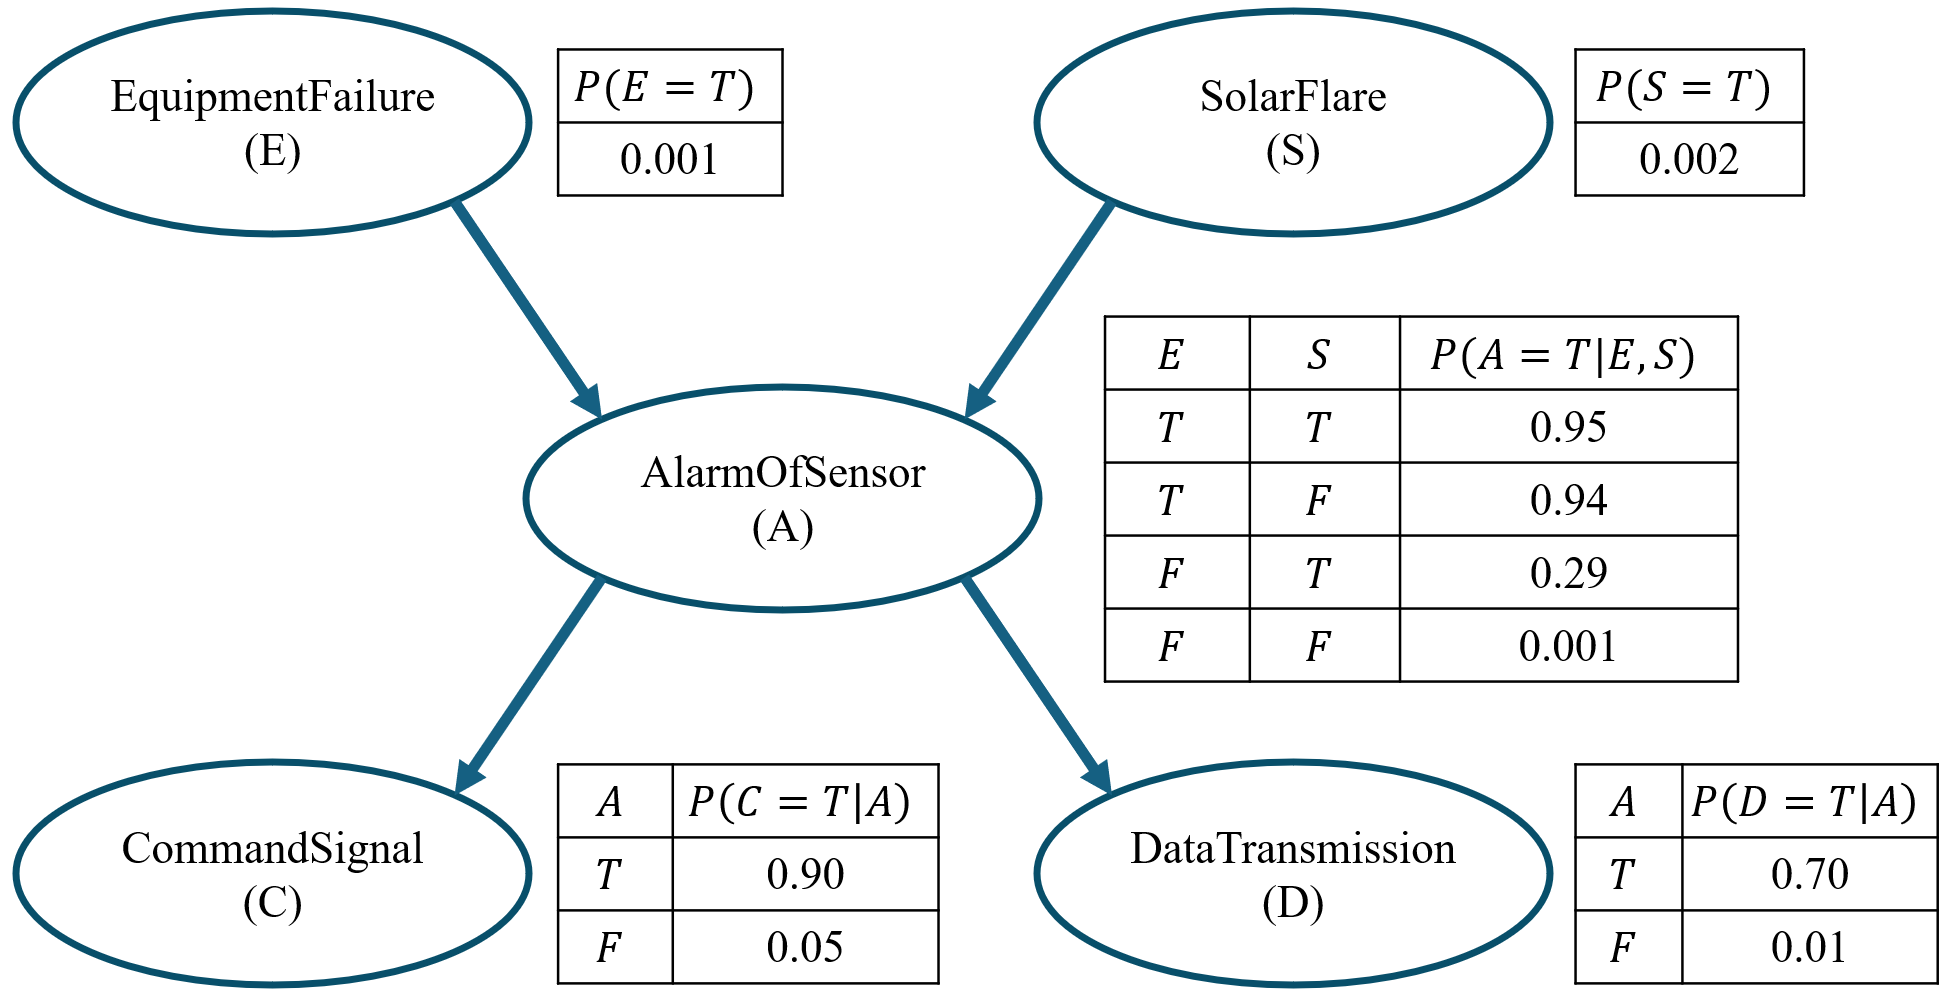

In [2]:
from IPython.display import Image

Image("./Percy_BN.png", width=600)

## Your Tasks

You only need to submit the answers to Task 1 in this Problem 2. (But you will need to work through and understand the whole program to complete the task.)

You are expected to add your codes **ONLY** in the blocks noted by:

```python
'''---Your code starts here---'''

'''---Your code ends here----'''
```

Let's start!


<br>

## Comparing Two Knowledge Representations for Learning Effectiveness

In this problem, we compare the effects of using two different knowledge representations on learning effectiveness:

- **Logical Representation:** In this approach, each event—such as
`(EquipmentFailure = T, SolarFlare = F, AlertOfSensor = T, CommandSignal = T, DataTransmission = T)`
—is treated as an *indivisible atomic proposition*.

- **Bayesian Network Representation**: Here, the joint probability distribution is factored into a set of conditional probabilities, allowing for a more structured (factored) representation that explicitly captures the dependencies among variables.


For learning these representations, we can use maximum likelihood estimation. For example, the probability of an event $a$ is estimated as:

<center>$P(a)=\frac{\#(a)}{N}$</center> 

where $\#(a)$ denotes the count of occurrences of $a$ in the dataset and $N$ is the number of samples. 

Similarly, the conditional probability can be estimated by: 

<center>$P(a|b)=\frac{\#(a\wedge b)}{\#(b)}$.</center>


Maximum likelihood can be problematic when the sample size is small, 
resulting in zero counts for some events. To handle this, smoothing is often used. One method of smoothing is to initialize the counts with a small constant $\alpha$ (instead of 0). 
This gives:

<center>$P(a)=\frac{\#(a)+\alpha}{N+K\alpha}$</center>   
<center>$P(a|b)=\frac{\#(a\wedge b)+\alpha}{\#(b)+K\alpha}$</center> when $a$ can take $K$ possible values. 

When $\alpha=1$,this is called _Laplace smoothing_, named after Pierre-Simon Laplace who used it to estimate the probability that the sun will rise tomorrow.

### Basic Code and Descriptions:

Consider the following code and descriptions.

##### `BayesNet()`

A `BayesNet` is a directed graph (as illustrated in the diagram above) where each node represents a random variable, and the edges represent parent&rarr;child relationships. You can create an empty graph using`BayesNet`, and then add variables one at a time with the method call`.add(`*variable_name, parent_names, cpt*`)`. Here, the variable names must be provided as strings, and every parent listed in `parent_names` must have been added beforehand.

##### `Variable(`*name, cpt, parents*`)`

A `Variable` represents a random variable (depicted as the ovals in the diagram above). Its value is probabilistically determined by the values of its parent variables, as specified by its conditional probability table (CPT). Once the values of the parents are known, the variable is conditionally independent of all other variables. For example, if the truth value of `AlertOfSensor` is known, then the probability of `CommandSignal` is fully determined, and evidence about the other variables will not provide additional information about `CommandSignal`. Each row of the CPT corresponds to a specific ordering of the parent variables as provided in the parents list.

We will only support variables that have a finite, discrete domain; continuous values are not permitted.

##### `CPTable(`*rows, parents*`)`

A `CPTable` (Conditional Probability Table) specifies the probability of each possible outcome of a random variable, given particular values of its parent variables. Essentially, a `CPTable` is a mapping (i.e., `{tuple: probdist, ...}`) where each tuple lists the values of the parent variables in a defined order, and each corresponding probability distribution details the outcomes for the variable given those parent values. For example, the `CPTable` for `AlertOfSensor` in the diagram above is represented as follows:

    CPTable({(T, T): 0.95,
             (T, F): 0.94,
             (F, T): 0.29,
             (F, F): 0.001},
            [EquipmentFailure, SolarFlare])
            
*How do you interpret this?*

Consider the second row, "`(T, F): 0.94`". This indicates that when the first parent (`EquipmentFailure`) is true and the second parent (`SolarFlare`) is false, the probability of `AlertOfSensor` being true is 0.94. 

Note that the `(T, F): 0.94` entry is a shorthand for the probability distribution `ProbDist({T: 0.94, F: 0.06})`.

In [ ]:
from collections import defaultdict, Counter
import itertools
import math
import random

In [ ]:
class BayesNet(object):
    "Bayesian network: a graph of variables connected by parent links."

    def __init__(self):
        self.variables = []  # List of variables, in parent-first topological sort order
        self.lookup = {}  # Mapping of {variable_name: variable} pairs

    def add(self, name, parentnames, cpt):
        "Add a new Variable to the BayesNet. Parentnames must have been added previously."
        parents = [self.lookup[name] for name in parentnames]
        var = Variable(name, cpt, parents)
        self.variables.append(var)
        self.lookup[name] = var
        return self

In [ ]:
class Variable(object):
    "A discrete random variable; conditional on zero or more parent Variables."

    def __init__(self, name, cpt, parents=()):
        "A variable has a name, list of parent variables, and a Conditional Probability Table."
        self.__name__ = name
        self.parents = parents
        self.cpt = CPTable(cpt, parents)
        self.domain = set(itertools.chain(*self.cpt.values()))  # All the outcomes in the CPT

    def __repr__(self): return self.__name__

In [ ]:
class Factor(dict): "An {outcome: frequency} mapping."

In [ ]:
class ProbDist(Factor):
    """A Probability Distribution is an {outcome: probability} mapping. 
    The values are normalized to sum to 1.
    ProbDist(0.75) is an abbreviation for ProbDist({T: 0.75, F: 0.25})."""

    def __init__(self, mapping=(), **kwargs):
        if isinstance(mapping, float):
            mapping = {T: mapping, F: 1 - mapping}
        self.update(mapping, **kwargs)
        normalize(self)

In [ ]:
class Evidence(dict):
    "A {variable: value} mapping, describing what we know for sure."

In [ ]:
class CPTable(dict):
    "A mapping of {row: ProbDist, ...} where each row is a tuple of values of the parent variables."

    def __init__(self, mapping, parents=()):
        """Provides two shortcuts for writing a Conditional Probability Table. 
        With no parents, CPTable(dist) means CPTable({(): dist}).
        With one parent, CPTable({val: dist,...}) means CPTable({(val,): dist,...})."""
        if len(parents) == 0 and not (isinstance(mapping, dict) and set(mapping.keys()) == {()}):
            mapping = {(): mapping}
        for (row, dist) in mapping.items():
            if len(parents) == 1 and not isinstance(row, tuple):
                row = (row,)
            self[row] = ProbDist(dist)

In [ ]:
class Bool(int):
    "Just like `bool`, except values display as 'T' and 'F' instead of 'True' and 'False'"
    __str__ = __repr__ = lambda self: 'T' if self else 'F'

In [ ]:
def P(var, evidence={}):
    "The probability distribution for P(variable | evidence), when all parent variables are known (in evidence)."
    row = tuple(evidence[parent] for parent in var.parents)
    return var.cpt[row]

In [ ]:
T = Bool(True)
F = Bool(False)

In [ ]:
def normalize(dist):
    "Normalize a {key: value} distribution so values sum to 1.0. Mutates dist and returns it."
    total = sum(dist.values())
    for key in dist:
        dist[key] = dist[key] / total
        assert 0 <= dist[key] <= 1, "Probabilities must be between 0 and 1."
    return dist

In [ ]:
def sample(probdist):
    "Randomly sample an outcome from a probability distribution."
    r = random.random()  # r is a random point in the probability distribution
    c = 0.0  # c is the cumulative probability of outcomes seen so far
    for outcome in probdist:
        c += probdist[outcome]
        if r <= c:
            return outcome

In [ ]:
def all_rows(net):
    """
    Generates all possible combinations of variable assignments for a given network.

    Args:
        net (Network): A network object containing variables with defined domains.

    Returns:
        itertools.product: An iterator over all possible combinations of variable assignments.
    """
    return itertools.product(*[var.domain for var in net.variables])

In [ ]:
def globalize(mapping):
    "Given a {name: value} mapping, export all the names to the `globals()` namespace."
    globals().update(mapping)

### Building the Safe Missions Bayesian Network

We can now specify Persy the Mars Rover's network as a Bayesian network.

The network models the following:
- **EquipmentFailure** (``E``): a rare malfunction in Persy's equipment.
- **SolarFlare** (``S``): a rare burst of solar activity affecting Mars.
- **AlertOfSensor** (``A``): an alert triggered if either an equipment failure or a solar flare occurs.
- **CommandSignal** (``C``): a signal sent from Mission Control when a sensor alert is detected.
- **DataTransmission** (``D``): a data transmission sent from Persy when a sensor alert is detected.

In [ ]:
persy_net = (BayesNet()
             .add('E', [], 0.001)
             .add('S', [], 0.002)
             .add('A', ['E', 'S'], {(T, T): 0.95, (T, F): 0.94, (F, T): 0.29, (F, F): 0.001})
             .add('C', ['A'], {T: 0.90, F: 0.05})
             .add('D', ['A'], {T: 0.70, F: 0.01}))

In [ ]:
# Make EquipmentFailure, SolarFlare, etc. be global variables
globalize(persy_net.lookup)
persy_net.variables

In [ ]:
# Probability distribution of an EquipmentFailure
P(E)

In [ ]:
# Probability of AlertOfSensor being triggered, given an EquipmentFailure and no SolarFlare:
P(A, {E: T, S: F})

### Comparing Learning Effectiveness: Logical vs. Bayesian Network Representations

We aim to learn the probability distribution over the five variables `EquipmentFailure`, `SolarFlare`, `AlertOfSensor`, `CommandSignal`, and `DataTransmission` using two approaches in order to compare their learning effectiveness.

**Approach 1: Logical Represenation - Atomic Proposition Model** 

The first method treats the complete state as atomic and learns a joint distribution over the five variables, corresponding to a *logical proposition representation* (i.e., each event or complete state is interpreted as a single proposition in a logical framework).

**Approach 2: Bayesian Network Representation**

The second method factors the overall distribution as a *Bayesian network*, capturing the conditional dependencies among the variables.

#### Step 0: Preparing the Data

We have previously generated 50 instances of training and test data from the Bayesian network specified in `persy_net`. 

We now load the training and test data.

For both training and test data, each row corresponds to a complete state of the five variables, with the variables **ordered as** `(E,S,A,C,D)`.

In [ ]:
import pickle

# load training and test files
with open('persydata/data_train.pkl', 'rb') as trainfile:
    train_data = pickle.load(trainfile)
    trainfile.close()
with open('persydata/data_test.pkl', 'rb') as testfile:
    test_data = pickle.load(testfile)
    testfile.close()


### Aproach 1: Learning the Atomic Proposition Model 

#### Step 1.1: Learning the Distribution

First, we learn an *atomic proposition model* as shown below. We employ the smoothing method described previously, where $\alpha$is the pseudo-count variable.
<br>

In [ ]:
import math

In [ ]:
pseudo_count = 0.1
# Get all possible combinations of variables from persy_net
persy_net_rows = all_rows(persy_net)
atomic_model_counts = {}
# Initialize with pseudo_count
for row in persy_net_rows:
    atomic_model_counts[row] = pseudo_count
# Count number of times each state is observed in the training data
for row in train_data:
    atomic_model_counts[row] += 1
# Normalize to construct probability distribution
atomic_model_joint = normalize(atomic_model_counts)


#### Step 1.2: Evaluating the Quality of Learned Model. 

We now evaluate the quality of the learned models using the test data. 

A common evaluation metric is the *likelihood of the test data given the learned model* — the higher the likelihood, the better the model. 

Since likelihood values can be very small, we typically use the log likelihood instead; the log function is monotonic and preserves the model ranking.

**Note**: Log likelihood values are generally negative. Therefore, we use the negative log likelihood, which yields a positive value — in this case, *the lower the negative log likelihood, the better the model*. When log base two is used, this measure corresponds to *the description length of the data in bits when compressed with an optimal data compressor using the learned model*; this interpretation may be easier to relate to.


In [ ]:
atomic_test_length = 0
for row in test_data:
    atomic_test_length -= math.log2(atomic_model_joint[row])

In [ ]:
print('Compressed test data length using estimated atomic model:', atomic_test_length, 'bits')

### Comparison with Base Model

We can compare this against the performance of the `persy_net` model,as shown above, which was used to generate the data. The `persy_net` model is optimal on average (or for very large test sets), though it may not be optimal for any specific small test set. 

We compute its joint distribution using the code below.


In [ ]:
def joint_distribution(net):
    "Given a Bayes net, create the joint distribution over all variables."
    return ProbDist({row: prod(P_xi_given_parents(var, row, net)
                               for var in net.variables)
                     for row in all_rows(net)})

In [ ]:
def P_xi_given_parents(var, row, net):
    "The probability that var = xi, given the values in this row."
    dist = P(var, Evidence(zip(net.variables, row)))
    xi = row[net.variables.index(var)]
    return dist[xi]

In [ ]:
def prod(numbers):
    "The product of numbers: prod([2, 3, 5]) == 30. Analogous to `sum([2, 3, 5]) == 10`."
    result = 1
    for x in numbers:
        result *= x
    return result

The performance using `persy_net` is computed in the same way.

In [ ]:
persy_net_joint = joint_distribution(persy_net)
persy_test_length = 0
for row in test_data:
    persy_test_length -= math.log2(persy_net_joint[row])

In [ ]:
print('Compressed test data length using persy_net:', persy_test_length, 'bits')

### Approach 2: Learning the Factored Bayesian Network

We now want to learn and evaluate the model from the training data in factored form as a *Bayesian network*. 

**Note**: This Bayesian network has the same structure - nodes and links, as in `persy_net` above, but all the conditional probabilities have been removed. 

The following helper functions may be useful for you.

In [ ]:
def count_rows(var_values, net):
    "Count the number of rows in the training data that match the variable values"
    num_match = 0
    for row in train_data:
        if match(row, var_values, net):
            num_match += 1
    return num_match

In [ ]:
def match(row, var_values, net):
    "Does the row match the variable values"
    return all(var_values[v] == row[net.variables.index(v)]
               for v in var_values)

In [ ]:
# Example use
count_command_data = count_rows({C: T, D: T}, persy_net)
print('Number of times both CommandSignal and DataTransmission occurred in the training set:', count_command_data)

### Task 1: 

#### Step 2.1: Learning the Distribution

You should now write code to estimate each conditional distribution in the network from the training data, assuming that the structure of `persy_net` is correct. After estimating each conditional distribution, construct the network as the variable `estimated_net` so that it can be evaluated in the code provided later.


In [ ]:
# --- Problem 2 Task 1: your code starts here---

estimated_net = None

# ---Problem 2 Task 1: your code ends here---

#### Step 2.2: Evaluating the Quality of Learned Model. 

We now evaluate the estimated Bayesian network `estimated_net`.

In [ ]:
estimated_joint = joint_distribution(estimated_net)
estimated_test_length = 0
for row in test_data:
    estimated_test_length -= math.log2(estimated_joint[row])

In [ ]:
print('Compressed test data length using estimated_net:', estimated_test_length, 'bits')
print('Previously computed compressed test data length using estimated atomic model:', atomic_test_length, 'bits')
print('Previously computed compressed test data length using persy_net:', persy_test_length, 'bits')


### Conclusion and Lessons Learned

In this problem, we examined two approaches to AI representation and reasoning: an atomic (logical proposition) representation and a factored Bayesian network. The factored model, which explicitly captures dependencies, generally produced more efficient models with shorter compressed test data lengths, as seen with `persy_net`. By contrast, the atomic model—though straightforward—was less efficient, illustrating the cost of not leveraging variable dependencies.

We also gained practical experience in estimating probability distributions, addressing data sparsity through smoothing techniques, and evaluating models using log-likelihood. These findings highlight the importance of selecting an appropriate representation for AI tasks and balancing simplicity with expressiveness.

## Submission

After the completion of the tasks, **copy** your solutions to the `./solution2.py` file indicated by the respective placeholders in the file.

End of Problem 2.

## Acknowledgments

The programming assignment is adapted from description and code in the module probability4e.ipny from the  Artificial Intelligence: A Modern Approach repository. 
